# OCR cyrillic

## Imports

In [9]:
# !pip install "python-doctr[torch,viz,html,contrib]"

In [10]:
import gc
import re
import json
import random
from itertools import chain
from tqdm.auto import tqdm
from typing import List, Optional
import difflib

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageEnhance

import torch
from doctr.io import DocumentFile
from doctr.models import ocr_predictor, recognition, detection

from torchmetrics.text import CharErrorRate, WordErrorRate
from torchmetrics.functional.text import char_error_rate, word_error_rate
import Levenshtein

from castom_utils import load_config, Ansi

In [11]:
def highlight_diff(gt, pred):
    """
    Функция для выделения ошибок в предсказанном тексте
    """
    mather = difflib.SequenceMatcher(None, gt, pred)
    result = []
    for tag, i1, i2, j1, j2 in mather.get_opcodes():
        part_txt = pred[j1:j2]
        
        match tag:
            case 'equal':
                result.append(part_txt)
            case 'replace' | 'insert':
                if part_txt == ' ':
                    result.append(f'{Ansi.red}[SPACE]{Ansi.end}')
                else:
                    result.append(f'{Ansi.red}{part_txt}{Ansi.end}')
            case 'delete':
                result.append(f'{Ansi.red}{Ansi.bold}[DEL]{Ansi.end}')
                
    return ''.join(result)

In [12]:
def get_predict_doctr(model, img_array, return_boxes=False):
    # Получаем размеры изображения
    height, width = img_array.shape[:2]

    # Прогноз модели
    output = model([img_array])
    pred_text = output.render()

    if not return_boxes:
        return pred_text

    # Получаем координаты боксов
    boxes = []
    pages = output.pages
    for page in pages:
        for block in page.blocks:
            for line in block.lines:
                for word in line.words:
                    # tuple(tuple, tuple) -->  list
                    bbox = list(chain(*word.geometry))
                    # Денормируем координаты
                    bbox = [int(i * j) for i, j in zip(bbox, [width, height, width, height])]
                    boxes.append(bbox)

    return pred_text, boxes, 'rectangle'

In [13]:
def calculation_score(model, predict_func, path_dataset):
    """
    Расчет Levenshtein distance и Levenshtein ratio
    """
    gc.collect()
    torch.cuda.empty_cache()
    
    with open(path_dataset.joinpath('labels.json'), 'r', encoding='utf-8') as file:
        annotations = json.load(file)

    lengths = {
        'gt': {
            'char': [],
            'word': []
        },
        'pred': {
            'char': [],
            'word': []
        }
    }
    ed_list, ed_norm_list = [], []
    cer_list, wer_list = [], []
    
    for img_name, gt_text in tqdm(annotations.items()):
        img_path = path_dataset.joinpath('images', img_name)
        img = Image.open(img_path).convert('RGB')
        img_array = np.array(img)

        pred_text = predict_func(model, img_array, return_boxes=False)
        
        ed = Levenshtein.distance(gt_text, pred_text)
        ed_norm = 1 - (ed / (len(gt_text) + len(pred_text)))
        cer = char_error_rate(pred_text, gt_text)  # CharErrorRate
        wer = word_error_rate(pred_text, gt_text)

        # Записываем длину текста в символах и отдельных словах
        lengths['gt']['char'].append(len(gt_text))
        lengths['gt']['word'].append(len(gt_text.split()))
        lengths['pred']['char'].append(len(pred_text))
        lengths['pred']['word'].append(len(pred_text.split()))
        
        ed_list.append(ed)
        ed_norm_list.append(ed_norm)
        cer_list.append(cer)
        wer_list.append(wer)

    print(
        f"Lengths GT:   (chars: {np.mean(lengths['gt']['char']):.0f}, words: {np.mean(lengths['gt']['word']):.0f})\n"
        f"Lengths pred: (chars: {np.mean(lengths['pred']['char']):.0f}, words: {np.mean(lengths['pred']['word']):.0f})\n\n"
        f"ED:      {Ansi.bold}{np.mean(ed_list):.4f}{Ansi.end}\n"
        f"ED_norm: {Ansi.bold}{np.mean(ed_norm_list):.4f}{Ansi.end}\n\n"
        f"CER:     {Ansi.bold}{np.mean(cer_list):.4f}{Ansi.end}\n"
        f"WER:     {Ansi.bold}{np.mean(wer_list):.4f}{Ansi.end}"
    )

In [76]:
def show_predict(model, predict_func, path_dataset, img_name, img_size=7, subtitle=''):
    """
    Отрисовка bboxes и получение предсказания для одного изображения
    """
    gc.collect()
    torch.cuda.empty_cache()

    with open(path_dataset.joinpath('labels.json'), 'r', encoding='utf-8') as file:
        annotations = json.load(file)
    gt_text = annotations[img_name]

    img_path = path_dataset.joinpath('images', img_name)
    img = Image.open(img_path).convert('RGB')
    img_array = np.array(img)
    draw = ImageDraw.Draw(img)

    # Получаем предсказания модели
    pred_text, boxes, boxmode = predict_func(model, img_array, return_boxes=True)

    if boxes is not None:
        for bbox in boxes:
            getattr(draw, boxmode)(bbox, outline='green', width=2)

    if subtitle != '':
        subtitle = ' | ' + subtitle

    plt.figure(figsize=(img_size, img_size))
    plt.title(img_name + subtitle)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Выделение ошибок предсказания
    pred_text_highlight = highlight_diff(gt_text, pred_text)

    # Расчет метрик
    edit_dist = Levenshtein.distance(gt_text, pred_text)
    edit_dist_norm = 1 - (edit_dist / (len(gt_text) + len(pred_text)))
    cer = char_error_rate(pred_text, gt_text)
    wer = word_error_rate(pred_text, gt_text)
    
    print(
        f'ED:      {Ansi.bold}{edit_dist}{Ansi.end}\n'
        f'ED_norm: {Ansi.bold}{edit_dist_norm:.4f}{Ansi.end}\n\n'
        f'CER:     {Ansi.bold}{cer:.4f}{Ansi.end}\n'
        f'WER:     {Ansi.bold}{wer:.4f}{Ansi.end}\n\n'
        f'{"-" * 80}\n'
        f'{Ansi.bold}{Ansi.underline}Ground Truth{Ansi.end} {Ansi.bold}(c:{len(gt_text)}, w:{len(gt_text.split())}){Ansi.end}\n'
        f'{gt_text}\n'
        f'{"-" * 80}\n'
        f'{Ansi.bold}{Ansi.underline}Prediction{Ansi.end} {Ansi.bold}(c:{len(pred_text)}, w:{len(pred_text.split())}){Ansi.end}\n'
        f'{pred_text_highlight}\n'
        f'{"-" * 80}\n'
    )

In [15]:
SEED = 42

IS_CUDA = torch.cuda.is_available()
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'torch use: {Ansi.green}{Ansi.bold}{DEVICE}{Ansi.end}', 
      f'({torch.cuda.get_device_name()})' 
      if torch.cuda.is_available() else '')

torch use: cuda (AMD Radeon RX 7800 XT)


## Config

При необходимости редактируем конфиг и записываем в файл.  
Это сделано для синхронизации общих переменных между несколькими Jupyter Notebooks.

In [16]:
def make_config(path: str = 'config.yaml'):
    config = {
        'vocab_category': {
            '1_number': '0123456789',
            '2_symbol': "!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~ €₽№°",  # «»—
            '3_ru_char': 'АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯабвгдеёжзийклмнопрстуфхцчшщъыьэюя',
            # '4_en_char': 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz',
            # '5_greek_char': 'αβγΔδεζηΘθιλμνΞξπρΣσ/ςτυφΨψΩω'
        },
        'path_dataset_synthetic': 'dataset_synthetic',
        'path_dataset_documents': 'dataset_documents',
        'path_pdf_files': 'pdf_files',
        'path_models_save': 'models_save',
        'path_models_best': 'models_best',
        'path_fonts': 'fonts',
    }

    with open(path, 'w', encoding='utf-8') as file:
        yaml.dump(config, file, allow_unicode=True)


# make_config()

Загружаем конфиг из файла

In [17]:
CFG = load_config()

Config is loaded!
A list of all characters used:
0123456789!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ €₽№°АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯабвгдеёжзийклмнопрстуфхцчшщъыьэюя


Подгружаем обученные веса

## Data preparation and model training

За основу возьмем модели из библиотеки **[docTR](https://github.com/mindee/doctr)**, которые дообучим под нашу задачу.

Для обучения моделей необходимы тренировочные датасеты. Подход к их созданию описан в ноутбуке **[synthetic_datasets.ipynb](synthetic_datasets.ipynb)**.

В ноутбуках **[train_recognition.ipynb](train_recognition.ipynb)** и **[train_detection.ipynb](train_detection.ipynb)** описан процесс обучения модели распознавания и модели детекции.

## Load weights

In [18]:
state_recognition = torch.load(
    CFG.path_models_best / 'best_vitstr_small.pth', 
    map_location=DEVICE, 
    weights_only=True
)

state_detection = torch.load(
    CFG.path_models_best / 'best_linknet_resnet18.pth', 
    map_location=DEVICE, 
    weights_only=True
)

Загружаем веса в модели распознавания и детекции

In [19]:
model_recognition = recognition.vitstr_small(vocab=CFG.vocab).to(DEVICE)
model_recognition.load_state_dict(state_recognition['model'])

model_detection = detection.linknet_resnet18().to(DEVICE)
model_detection.load_state_dict(state_detection['model'])

/home/lake/anaconda3/envs/lime/lib/python3.11/site-packages/doctr/models/utils/pytorch.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(archive_p

<All keys matched successfully>

Получаем цельную модель для OCR

In [20]:
model = ocr_predictor(det_arch=model_detection, reco_arch=model_recognition).to(DEVICE)

## Test

В качестве метрик возьмем следующие:
1. **Edit distance** (**Levenshtein distance**)

2. **Edit distance norm:**  $ED norm = 1 - \frac{distance}{len1 + len2}$

3. **CER (Char Error Rate):**  $WER = \frac{S + D + I}{N} = \frac{S + D + I}{S + D + C}$, где
    - **S** is the number of substitutions,
    - **D** is the number of deletions,
    - **I** is the number of insertions,
    - **C** is the number of correct characters,
    - **N** is the number of characters in the reference (N=S+D+C).
<br><br>
4. **WER (Word Error Rate)** - рассчитывается аналогично **CER**, но на уровне отдельных слов, а не символов.

<br><br>
Ссылки на документацию:
- [Levenshtein.distance](https://rapidfuzz.github.io/Levenshtein/levenshtein.html#distance)
- [CER](https://torchmetrics.readthedocs.io/en/v0.8.2/text/char_error_rate.html)
- [WER](https://torchmetrics.readthedocs.io/en/v0.8.2/text/word_error_rate.html)

### Средняя точность на тестовом датасете

In [112]:
calculation_score(model, get_predict_doctr, CFG.path_dataset_documents)

  0%|          | 0/124 [00:00<?, ?it/s]

Lengths GT:   (chars: 1610, words: 288)
Lengths pred: (chars: 1626, words: 290)

ED:      45.2258
ED_norm: 0.9851

CER:     0.0300
WER:     0.1137


### Примеры работы модели

Несколько примеров работы модели. Красным цветом отмечены ошибки. На длинных текстах может отобразиться (выделиться красным цветом) больше ошибок, чем есть на самом деле, это особенность работы библиотеки difflib.

С текстом с простой структурой модель справляется относительно неплохо. Вот пару примеров.

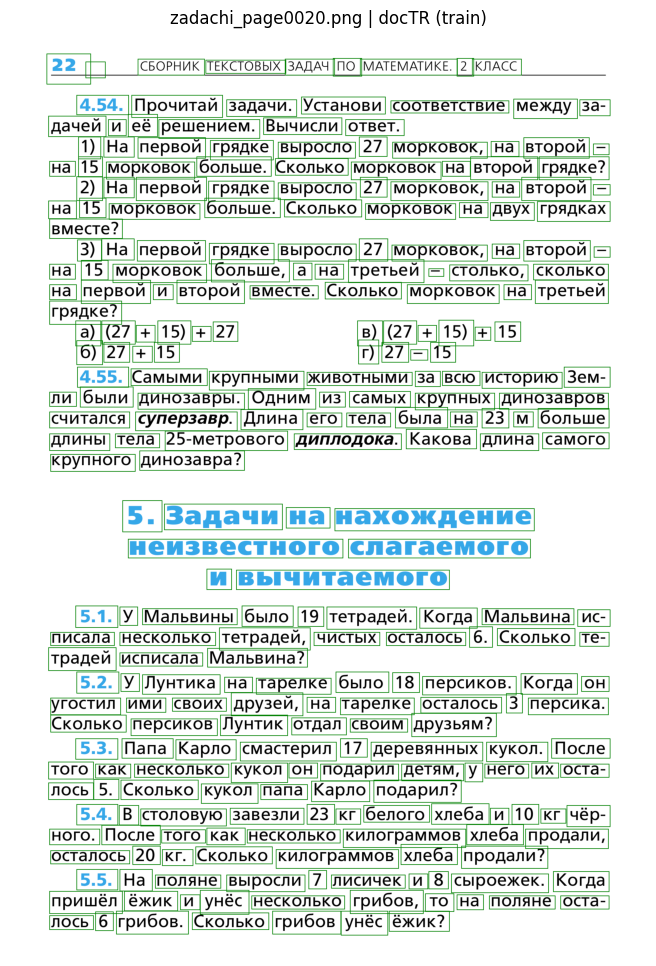

ED:      35
ED_norm: 0.9894

CER:     0.0211
WER:     0.0791

--------------------------------------------------------------------------------
Ground Truth (c:1657, w:278)
СБОРНИК ТЕКСТОВЫХ ЗАДАЧ ПО МАТЕМАТИКЕ. 2 КЛАСС
22
4.54. Прочитай задачи. Установи соответствие между за-
дачей и её решением. Вычисли ответ.
1) На первой грядке выросло 27 морковок, на второй –
на 15 морковок больше. Сколько морковок на второй грядке?
2) На первой грядке выросло 27 морковок, на второй –
на 15 морковок больше. Сколько морковок на двух грядках
вместе?
3) На первой грядке выросло 27 морковок, на второй –
на 15 морковок больше, а на третьей – столько, сколько
на первой и второй вместе. Сколько морковок на третьей
грядке?
а) (27 + 15) + 27
б) 27 + 15
в) (27 + 15) + 15
г) 27 – 15
4.55. Самыми крупными животными за всю историю Зем-
ли были динозавры. Одним из самых крупных динозавров
считался суперзавр. Длина его тела была на 23 м больше
длины тела 25‑метрового диплодока. Какова длина самого
крупного диноза

In [78]:
show_predict(
    model, 
    get_predict_doctr, 
    CFG.path_dataset_documents, 
    'zadachi_page0020.png', 
    img_size=12, 
    subtitle='docTR (train)'
)

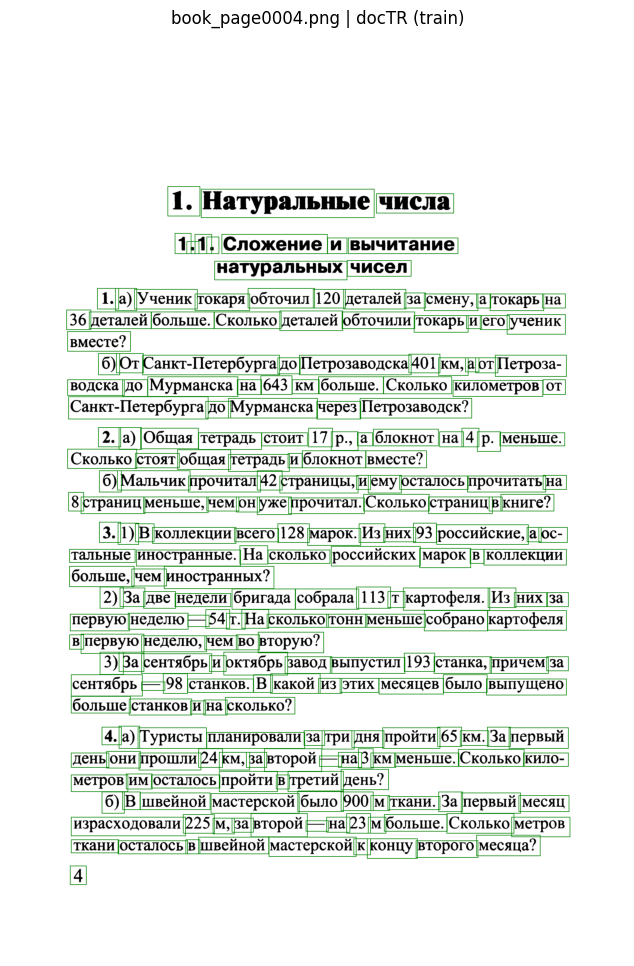

ED:      21
ED_norm: 0.9926

CER:     0.0149
WER:     0.0820

--------------------------------------------------------------------------------
Ground Truth (c:1408, w:244)
1. Натуральные числа
1.1. Сложение и вычитание
натуральных чисел
1. а) Ученик токаря обточил 120 деталей за смену, а токарь на
36 деталей больше. Сколько деталей обточили токарь и его ученик
вместе?
б) От Санкт-Петербурга до Петрозаводска 401 км, а от Петроза-
водска до Мурманска на 643 км больше. Сколько километров от
Санкт-Петербурга до Мурманска через Петрозаводск?
2. а) Общая тетрадь стоит 17 р., а блокнот на 4 р. меньше.
Сколько стоят общая тетрадь и блокнот вместе?
б) Мальчик прочитал 42 страницы, и ему осталось прочитать на
8 страниц меньше, чем он уже прочитал. Сколько страниц в книге?
3. 1) В коллекции всего 128 марок. Из них 93 российские, а ос-
тальные иностранные. На сколько российских марок в коллекции
больше, чем иностранных?
2) За две недели бригада собрала 113 т картофеля. Из них за
первую неделю — 54

In [79]:
show_predict(
    model, 
    get_predict_doctr, 
    CFG.path_dataset_documents, 
    'book_page0004.png', 
    img_size=12, 
    subtitle='docTR (train)'
)

Но на более сложных текстах, где, к примеру, присутствуют формулы и таблицы точность оставляет желать лучшего.

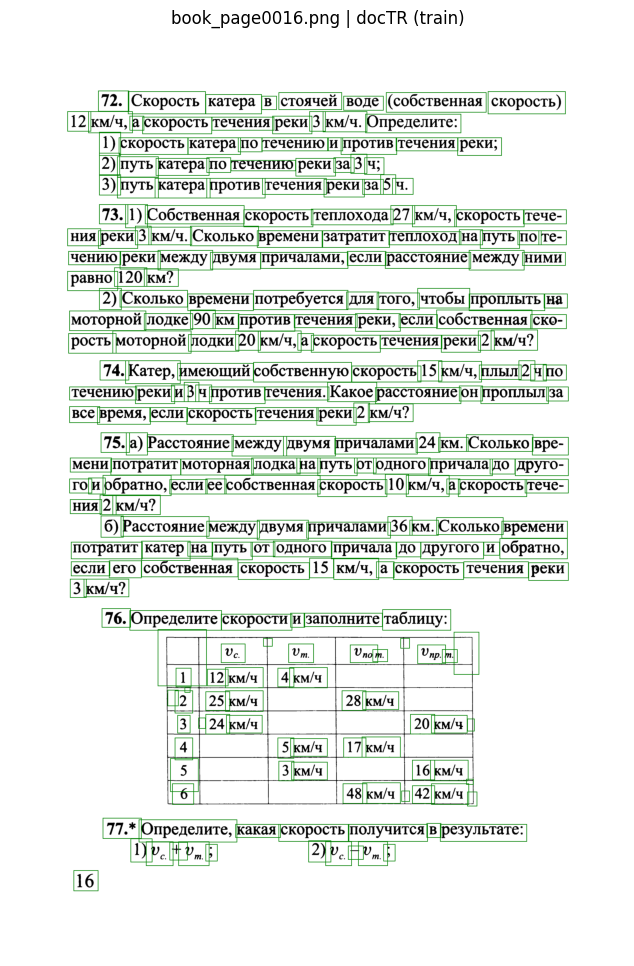

ED:      123
ED_norm: 0.9587

CER:     0.0834
WER:     0.2127

--------------------------------------------------------------------------------
Ground Truth (c:1474, w:268)
72. Скорость катера в стоячей воде (собственная скорость)
12 км/ч, а скорость течения реки 3 км/ч. Определите:
1) скорость катера по течению и против течения реки;
2) путь катера по течению реки за 3 ч;
3) путь катера против течения реки за 5 ч.
73. 1) Собственная скорость теплохода 27 км/ч, скорость тече-
ния реки 3 км/ч. Сколько времени затратит теплоход на путь по те-
чению реки между двумя причалами, если расстояние между ними
равно 120 км?
2) Сколько времени потребуется для того, чтобы проплыть на
моторной лодке 90 км против течения реки, если собственная ско-
рость моторной лодки 20 км/ч, а скорость течения реки 2 км/ч?
74. Катер, имеющий собственную скорость 15 км/ч, плыл 2 ч по
течению реки и 3 ч против течения. Какое расстояние он проплыл за
все время, если скорость течения реки 2 км/ч?
75. а) Расстояние ме

In [80]:
show_predict(
    model, 
    get_predict_doctr, 
    CFG.path_dataset_documents, 
    'book_page0016.png', 
    img_size=12, 
    subtitle='docTR (train)'
)

Видно, что на данном примере модель с текстом справилась неплохо, но на блоке с таблицей много ошибок. В данном аспекте модель требует доработок.  
Но тем не менее, мы получили среднюю метрику **WER: 0.1137** на всем тестовом датасете, что довольно неплохо, учитывая что с таблицами и формулами модель не была обучена работать, и с простым текстом она справилась бы лучше.

In [66]:
# # Получаем список всех изображений тестового датасета
# with open(CFG.path_dataset_documents / 'labels.json', 'r', encoding='utf-8') as file:
#     labels = json.load(file)
# img_names = list(labels.keys())

# random_images = np.random.choice(img_names, 3)
# for img_name in random_images:
#     show_predict(model, get_predict_doctr, CFG.path_dataset_documents, img_name, img_size=12)

# Testing ready-made solutions

Сравним полученные результаты с другими OCR моделями, которые изначально обучены для работы с русскоязычным текстом.

## EasyOCR

In [ ]:
#!pip install easyocr

In [82]:
import easyocr

In [83]:
def get_predict_easyocr(model, img_array, return_boxes=False):
    output = model.readtext(img_array)
    text_total, text_string, boxes = [], [], []
    current_bottom = None
    
    for bbox, txt, _ in output:
        if current_bottom is None:
            current_bottom = bbox[2][1]

        if bbox[2][1] > current_bottom + 15:
            text_total.append(' '.join(text_string))
            text_string = []
            current_bottom = bbox[2][1]

        boxes.append([tuple(cord) for cord in bbox])
        text_string.append(txt)

    text_total.append(' '.join(text_string))
    text_total = '\n'.join(text_total)
    
    if not return_boxes:
        return text_total
    
    return text_total, boxes, 'polygon'

In [84]:
model_easyocr = easyocr.Reader(['ru'], gpu=IS_CUDA)

### Средняя точность на тестовом датасете

In [120]:
calculation_score(model_easyocr, get_predict_easyocr, CFG.path_dataset_documents)

  0%|          | 0/124 [00:00<?, ?it/s]

Lengths GT:   (chars: 1610, words: 288)
Lengths pred: (chars: 1599, words: 284)

ED:      91.4677
ED_norm: 0.9706

CER:     0.0586
WER:     0.1683


### Пример работы модели

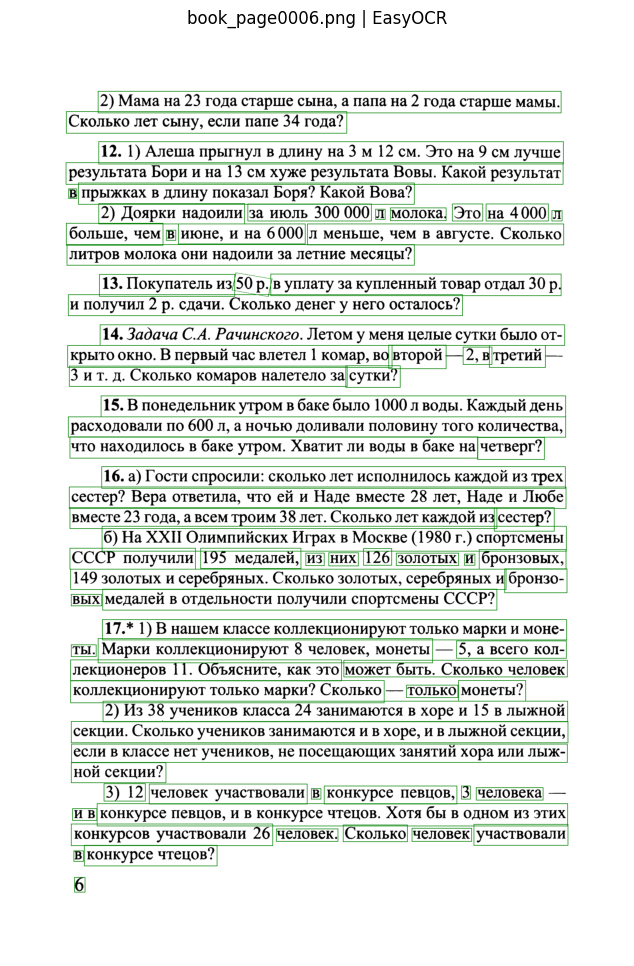

ED:      87
ED_norm: 0.9781

CER:     0.0437
WER:     0.1621

--------------------------------------------------------------------------------
Ground Truth (c:1990, w:364)
2) Мама на 23 года старше сына, а папа на 2 года старше мамы.
Сколько лет сыну, если папе 34 года?
12. 1) Алеша прыгнул в длину на 3 м 12 см. Это на 9 см лучше
результата Бори и на 13 см хуже результата Вовы. Какой результат
в прыжках в длину показал Боря? Какой Вова?
2) Доярки надоили за июль 300 000 л молока. Это на 4000 л
больше, чем в июне, и на 6 000 л меньше, чем в августе. Сколько
литров молока они надоили за летние месяцы?
13. Покупатель из 50 р. в уплату за купленный товар отдал 30 р.
и получил 2 р. сдачи. Сколько денег у него осталось?
14. Задача С А. Рачинского. Летом у меня целые сутки было от-
крыто окно. В первый час влетел 1 комар, во второй — 2, в третий —
3 и т. д. Сколько комаров налетело за сутки?
15. В понедельник утром в баке было 1000 л воды. Каждый день
расходовали по 600 л, а ночью доливали по

In [85]:
show_predict(
    model_easyocr, 
    get_predict_easyocr, 
    CFG.path_dataset_documents, 
    'book_page0006.png', 
    img_size=12, 
    subtitle='EasyOCR'
)

## Tesseract

In [127]:
# !pip install pytesseract

In [86]:
import pytesseract

In [87]:
def get_predict_tesseract(model, img_array, return_boxes=False):
    pred_text = model.image_to_string(img_array, lang='rus')
    
    if not return_boxes:
        return pred_text

    # boxes = model.image_to_boxes(img_array, lang='rus')
    # boxes = [list(map(int, bbox.split()[1:5])) for bbox in boxes.split('\n')][:50]
    
    return pred_text, None, 'rectangle'

### Средняя точность на тестовом датасете

In [176]:
calculation_score(pytesseract, get_predict_tesseract, CFG.path_dataset_documents)

  0%|          | 0/124 [00:00<?, ?it/s]

Lengths GT:   (chars: 1610, words: 288)
Lengths pred: (chars: 1621, words: 287)

ED:      33.8226
ED_norm: 0.9885

CER:     0.0232
WER:     0.0554


### Пример работы модели

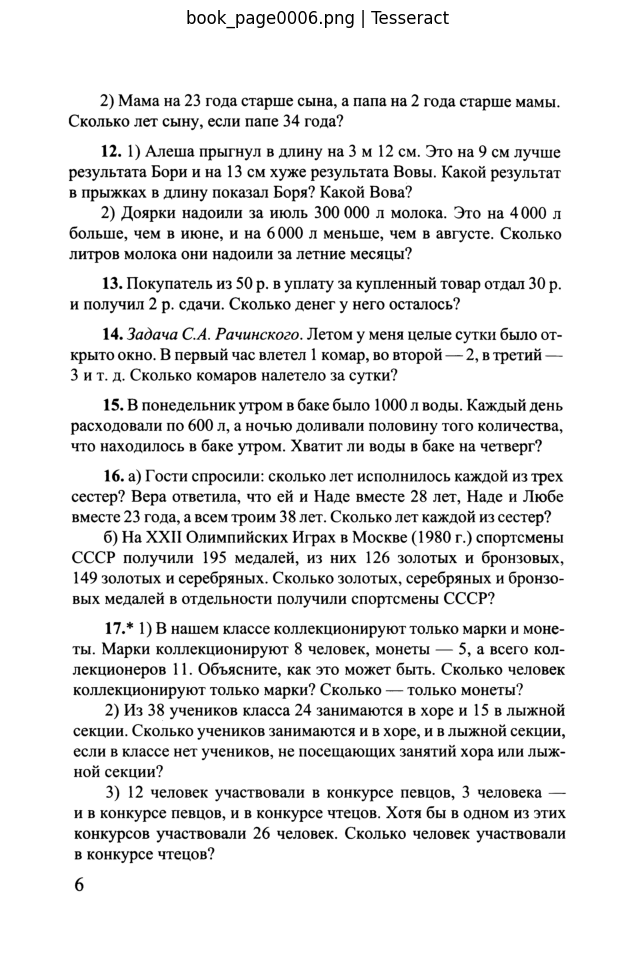

ED:      19
ED_norm: 0.9952

CER:     0.0095
WER:     0.0220

--------------------------------------------------------------------------------
Ground Truth (c:1990, w:364)
2) Мама на 23 года старше сына, а папа на 2 года старше мамы.
Сколько лет сыну, если папе 34 года?
12. 1) Алеша прыгнул в длину на 3 м 12 см. Это на 9 см лучше
результата Бори и на 13 см хуже результата Вовы. Какой результат
в прыжках в длину показал Боря? Какой Вова?
2) Доярки надоили за июль 300 000 л молока. Это на 4000 л
больше, чем в июне, и на 6 000 л меньше, чем в августе. Сколько
литров молока они надоили за летние месяцы?
13. Покупатель из 50 р. в уплату за купленный товар отдал 30 р.
и получил 2 р. сдачи. Сколько денег у него осталось?
14. Задача С А. Рачинского. Летом у меня целые сутки было от-
крыто окно. В первый час влетел 1 комар, во второй — 2, в третий —
3 и т. д. Сколько комаров налетело за сутки?
15. В понедельник утром в баке было 1000 л воды. Каждый день
расходовали по 600 л, а ночью доливали по

In [89]:
show_predict(
    pytesseract, 
    get_predict_tesseract, 
    CFG.path_dataset_documents, 
    'book_page0006.png', 
    img_size=12, 
    subtitle='Tesseract'
)

## PaddleOCR

In [181]:
# !pip install paddlepaddle==2.6.1 paddleocr

In [63]:
from paddleocr import PaddleOCR

In [64]:
def get_predict_paddle(model, img_array, return_boxes=False):
    output = model.ocr(img_array)
    text_total, text_string, boxes = [], [], []
    current_bottom = None

    for bbox, txt in output[0]:
        if current_bottom is None:
            current_bottom = bbox[2][1]

        if bbox[2][1] > current_bottom + 15:
            text_total.append(' '.join(text_string))
            text_string = []
            current_bottom = bbox[2][1]
            
        boxes.append([tuple(map(int, cord)) for cord in bbox])
        text_string.append(txt[0])

    text_total.append(' '.join(text_string))
    text_total = '\n'.join(text_total)

    if not return_boxes:
        return text_total
    
    return text_total, boxes, 'polygon'

In [69]:
model_paddle = PaddleOCR(lang='ru', use_angle_cls=True, show_log=False)

### Средняя точность на тестовом датасете

In [71]:
calculation_score(model_paddle, get_predict_paddle, CFG.path_dataset_documents)

  0%|          | 0/124 [00:00<?, ?it/s]

Lengths GT:   (chars: 1610, words: 288)
Lengths pred: (chars: 1505, words: 262)

ED:      633.4274
ED_norm: 0.7980

CER:     0.3904
WER:     0.6834


### Пример работы модели

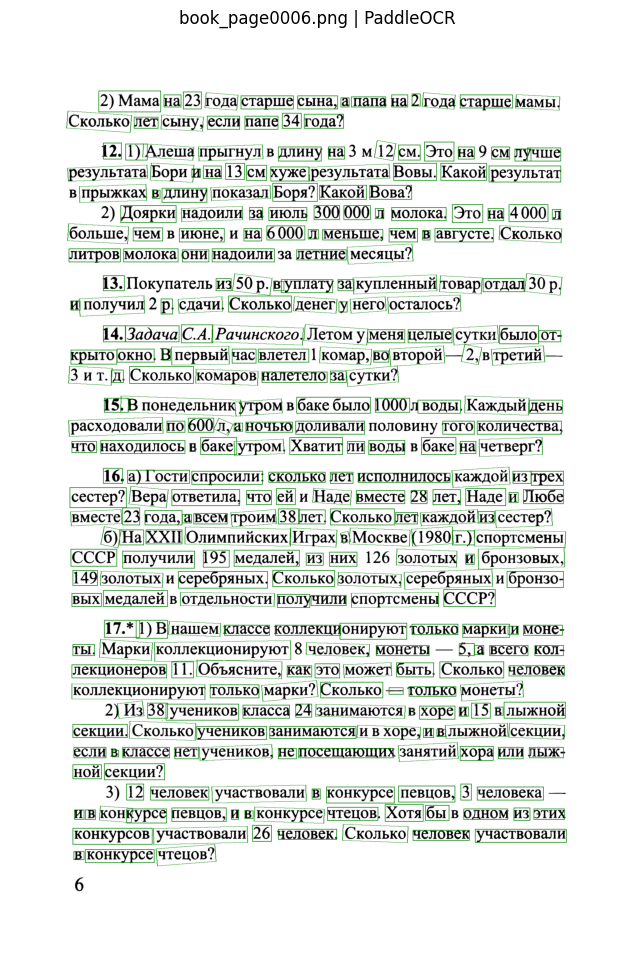

ED:      871
ED_norm: 0.7734

CER:     0.4377
WER:     0.7225

--------------------------------------------------------------------------------
Ground Truth (c:1990, w:364)
2) Мама на 23 года старше сына, а папа на 2 года старше мамы.
Сколько лет сыну, если папе 34 года?
12. 1) Алеша прыгнул в длину на 3 м 12 см. Это на 9 см лучше
результата Бори и на 13 см хуже результата Вовы. Какой результат
в прыжках в длину показал Боря? Какой Вова?
2) Доярки надоили за июль 300 000 л молока. Это на 4000 л
больше, чем в июне, и на 6 000 л меньше, чем в августе. Сколько
литров молока они надоили за летние месяцы?
13. Покупатель из 50 р. в уплату за купленный товар отдал 30 р.
и получил 2 р. сдачи. Сколько денег у него осталось?
14. Задача С А. Рачинского. Летом у меня целые сутки было от-
крыто окно. В первый час влетел 1 комар, во второй — 2, в третий —
3 и т. д. Сколько комаров налетело за сутки?
15. В понедельник утром в баке было 1000 л воды. Каждый день
расходовали по 600 л, а ночью доливали п

In [90]:
show_predict(
    model_paddle, 
    get_predict_paddle, 
    CFG.path_dataset_documents, 
    'book_page0006.png', 
    img_size=12, 
    subtitle='PaddleOCR'
)

## Summary

Резюмируем результаты тестов и составим сводную таблицу со средними значениями метрик **[CER](https://torchmetrics.readthedocs.io/en/v0.8.2/text/char_error_rate.html)** и **[WER](https://torchmetrics.readthedocs.io/en/v0.8.2/text/word_error_rate.html)**, которые показывают процент ошибок, совершенных моделью на уровне отдельных символов и на уровне отдельных слов соответственно.

| model | CER | WER |
| --- | --- | --- |
| docTR (train) | 0.0300 | 0.1137 |
| EasyOCR | 0.0586 | 0.1683 |
| Tesseract | 0.0232 | 0.0554 |
| PaddleOCR | 0.3904 | 0.6834 |

С нашим датасетом лучше всего справился Tesseract. Модель docTR, которую мы обучали, показала несколько худший результат. Возможно, что мы использовали излишне тяжелую recognition model, что повлияло на переобучение, стоит ппробовать более легковесные модели. Так же стоит попробовать применять более "мягкие" аугментации, так как изображения в тестовом датасете довольно качественные. Либо же взять более "сложный" датасет для оценки точности.

EasyOCR справился с задачей хуже, чем docTR. Замыкает таблицу PaddleOCR - эта модель "из коробки" на русскоязычном тексте отработала неудачно.